####How to run code?

*-> directly run colab*

## Mounting Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Adding libraries

In [47]:
!pip install plotly

In [48]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset,Subset,Dataset
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField as GADF
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from pyts.image import GramianAngularField
from torchvision.models import resnet18
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [49]:
pip install --upgrade scikit-learn

In [50]:
!pip install cuda-python

In [51]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [52]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


2.5.1+cu121
12.1
90100


In [53]:
torch.cuda.is_available()

True

In [54]:
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Portfolio Ridge Regression


### A: Set Up

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
%ls

 compustat_merged.csv
 custom_financial_dataset.csv
'DL_Project .ipynb'
'DL_Project _OG.ipynb'
 factors_jkp_transformed.csv
 factors_jkp_untransformed.csv
 helper_base.ipynb
 helper.py
 main.py
 merged_compustat_returns_cleaned_data.csv
 merged_compustat_returns_cleaned_data_mv_avg.csv
 merged_data_strict.csv
 processed_returns.csv
 __pycache__/
 README.md
'Report .pdf'


In [57]:
%cd drive/MyDrive/ML_Fin

[Errno 2] No such file or directory: 'drive/MyDrive/ML_Fin'
/content/drive/MyDrive/ML_Fin


In [73]:
%ls

 compustat_merged.csv
 custom_financial_dataset.csv
'DL_Project .ipynb'
'DL_Project _OG.ipynb'
 factors_jkp_transformed.csv
 factors_jkp_untransformed.csv
 helper_base.ipynb
 helper.py
 main.py
 merged_compustat_returns_cleaned_data.csv
 merged_compustat_returns_cleaned_data_mv_avg.csv
 merged_data_strict.csv
 processed_returns.csv
 __pycache__/
 README.md
'Report .pdf'


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


### B: Data Preprocessing

In [109]:
df = pd.read_csv("custom_financial_dataset.csv")

In [110]:
df.head()

,Unnamed: 0,PERMNO,PERMCO,cusip,Ticker,SICCD,NAICS,MthCalDt,MthRet,sprtrn,...,mostimportantdateutc,report_date,unified_sentiment,SMA_3,EMA_3,SMA_6,EMA_6,SMA_12,EMA_12,LOWESS
0,0,12920,53847,44951J10,IROQ,9999,522110,2015-06-30,-0.010180,-0.021012,...,2015-06-30,2015-06-30,0.922511,-0.004370,-0.004947,-0.003230,-0.002999,0.000799,-0.000639,0.004504
1,1,23660,6304,17290810,CTAS,2320,315210,2015-06-30,-0.017424,-0.021012,...,2015-03-18,2015-05-31,0.376630,0.012931,0.009303,0.013447,0.015965,0.026872,0.021479,0.021489
2,2,77507,11459,40417210,HFFC,6035,522110,2015-06-30,0.046207,-0.021012,...,2015-06-30,2015-06-30,-0.887585,0.011836,0.023634,0.016886,0.017181,0.010256,0.013720,0.017733
3,3,17144,20798,37033410,GIS,2041,311211,2015-06-30,-0.007658,-0.021012,...,2015-03-18,2015-05-31,0.384890,-0.002526,0.002112,0.010203,0.006803,0.008097,0.008699,0.006993
4,4,83411,14518,30049A10,EPM,1311,211111,2015-06-30,-0.038173,-0.021012,...,2015-05-07,2015-06-30,0.362895,0.040346,-0.009809,-0.013711,-0.013736,-0.035292,-0.020770,-0.033422


In [111]:
def keep_selec(df, list_ids, list_keep):
  ids_drop = [id for id in list_ids if id not in list_keep]
  return df.drop(ids_drop, axis=1)

In [112]:
list_ids = ['PERMNO', 'PERMCO', "Ticker", "SICCD", "NAICS", 'cik', 'datadate', 'tic', 'exchg', 'gvkey', 'conm', 'cusip', 'mostimportantdateutc', 'report_date', 'Unnamed: 0']

# TODO
# Add tickers you want to keep to the list_keep variable
list_keep = ['cusip']

In [113]:
df = keep_selec(df, list_ids, list_keep)

In [114]:
df.head()

,cusip,MthCalDt,MthRet,sprtrn,epspxy,epspiy,epsfiy,epsfxy,oiadpy,cshpry,...,dividend_change,repurchase_intensity,unified_sentiment,SMA_3,EMA_3,SMA_6,EMA_6,SMA_12,EMA_12,LOWESS
0,44951J10,2015-06-30,-0.010180,-0.021012,0.83,0.83,0.83,0.83,8.065,3.925,...,-0.028916,0.222912,0.922511,-0.004370,-0.004947,-0.003230,-0.002999,0.000799,-0.000639,0.004504
1,17290810,2015-06-30,-0.017424,-0.021012,3.51,3.68,3.63,3.46,696.407,115.900,...,1.163427,0.123293,0.376630,0.012931,0.009303,0.013447,0.015965,0.026872,0.021479,0.021489
2,40417210,2015-06-30,0.046207,-0.021012,0.51,0.51,0.51,0.51,18.345,7.055,...,0.000315,0.000000,-0.887585,0.011836,0.023634,0.016886,0.017181,0.010256,0.013720,0.017733
3,37033410,2015-06-30,-0.007658,-0.021012,2.02,2.02,1.97,1.97,2718.000,603.300,...,0.034984,0.065904,0.384890,-0.002526,0.002112,0.010203,0.006803,0.008097,0.008699,0.006993
4,30049A10,2015-06-30,-0.038173,-0.021012,0.13,0.13,0.13,0.13,8.855,32.817,...,0.010675,0.011997,0.362895,0.040346,-0.009809,-0.013711,-0.013736,-0.035292,-0.020770,-0.033422


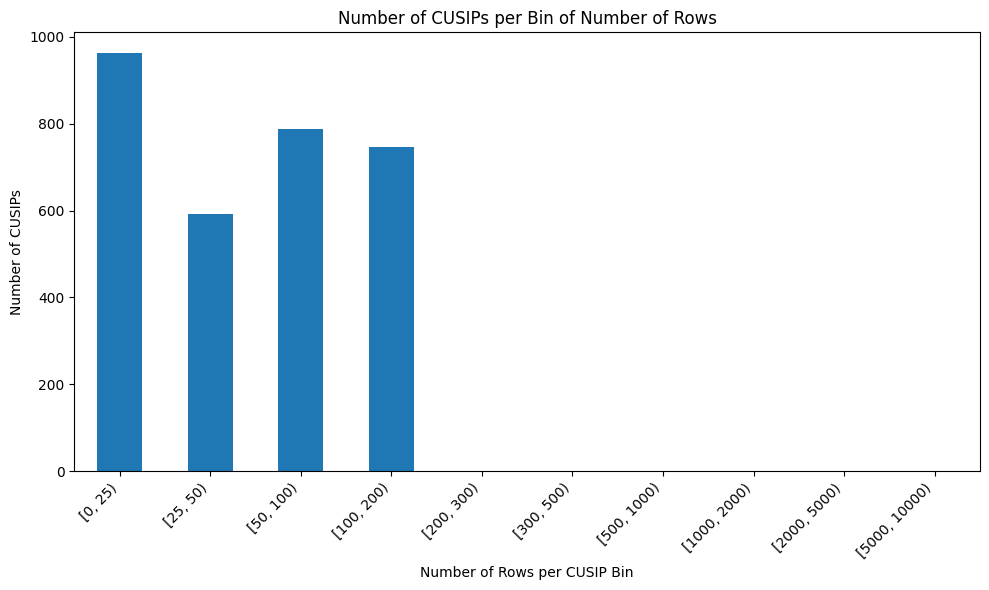

In [115]:
cusip_counts = df.groupby('cusip').size()

bins = [0, 25, 50, 100, 200, 300, 500, 1000, 2000, 5000, 10000]
cusip_bins = pd.cut(cusip_counts, bins=bins, right=False)

bin_counts = cusip_bins.value_counts().sort_index()

plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar')
plt.title('Number of CUSIPs per Bin of Number of Rows')
plt.xlabel('Number of Rows per CUSIP Bin')
plt.ylabel('Number of CUSIPs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

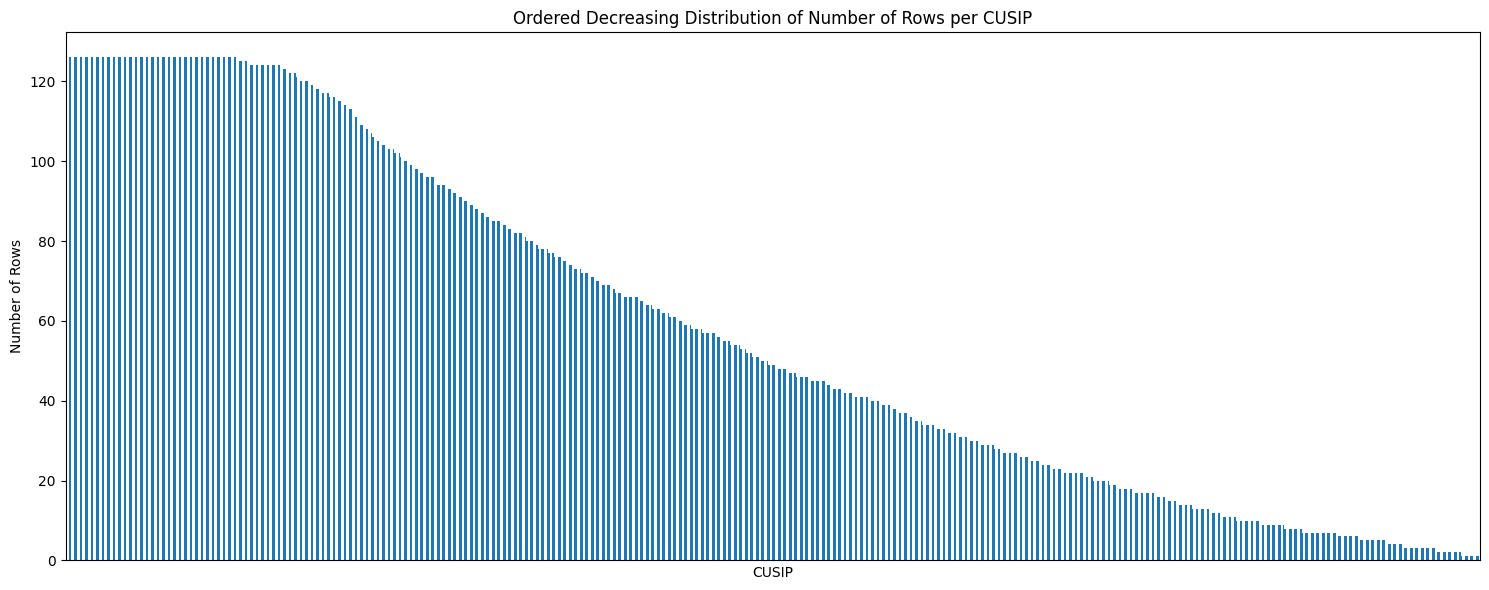

In [116]:
cusip_counts = df.groupby('cusip').size().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
cusip_counts.plot(kind='bar')
plt.title('Ordered Decreasing Distribution of Number of Rows per CUSIP')
plt.xlabel('CUSIP')
plt.ylabel('Number of Rows')
plt.xticks([])
plt.tight_layout()
plt.show()

In [117]:
# Only keep stocks that have >= 100 rows
# TODO: play with the cutoff variable
cutoff = 100
df_mini = df.groupby('cusip').count()
cusips = df_mini[df_mini['MthRet'] >= cutoff].index
len(cusips)

746

In [118]:
cusips

Index(['00095710', '00206R10', '00247410', '00282410', '00289620', '00423910',
       '00481610', '00508Y10', '00751Y10', '00847410',
       ...
       'G3673810', 'G491BT10', 'G7496G10', 'G8127610', 'G9456A10', 'H2906T10',
       'M7024010', 'N5374510', 'P1699413', 'Y2065G12'],
      dtype='object', name='cusip', length=746)

In [119]:
test_df = df[df['cusip']=='G491BT10']
print(len(test_df))
test_df.head(2)

126


,cusip,MthCalDt,MthRet,sprtrn,epspxy,epspiy,epsfiy,epsfxy,oiadpy,cshpry,...,dividend_change,repurchase_intensity,unified_sentiment,SMA_3,EMA_3,SMA_6,EMA_6,SMA_12,EMA_12,LOWESS
7259,G491BT10,2010-03-31,0.117857,0.058796,0.22,0.22,0.21,0.21,154.1,439.0,...,0.151671,0.0,0.107506,-0.013215,0.047387,0.000316,0.028769,0.044527,0.026014,0.023755
7935,G491BT10,2010-04-30,0.049293,0.014759,0.22,0.22,0.21,0.21,154.1,439.0,...,0.151671,0.0,0.048555,0.062674,0.048340,0.020321,0.034633,0.043464,0.029596,0.024047


In [120]:
# prompt: import content of helper_py.py file in local directory to use its methods

from importlib import reload
import helper

# If you modify helper_py.py, uncomment the line below to reload it
reload(helper)

<module 'helper' from '/content/drive/MyDrive/ML_Fin/helper.py'>

In [121]:
helper.plot_moving_averages_with_dropdown(test_df, "S")

In [122]:
helper.plot_moving_averages_with_dropdown(test_df, "E")

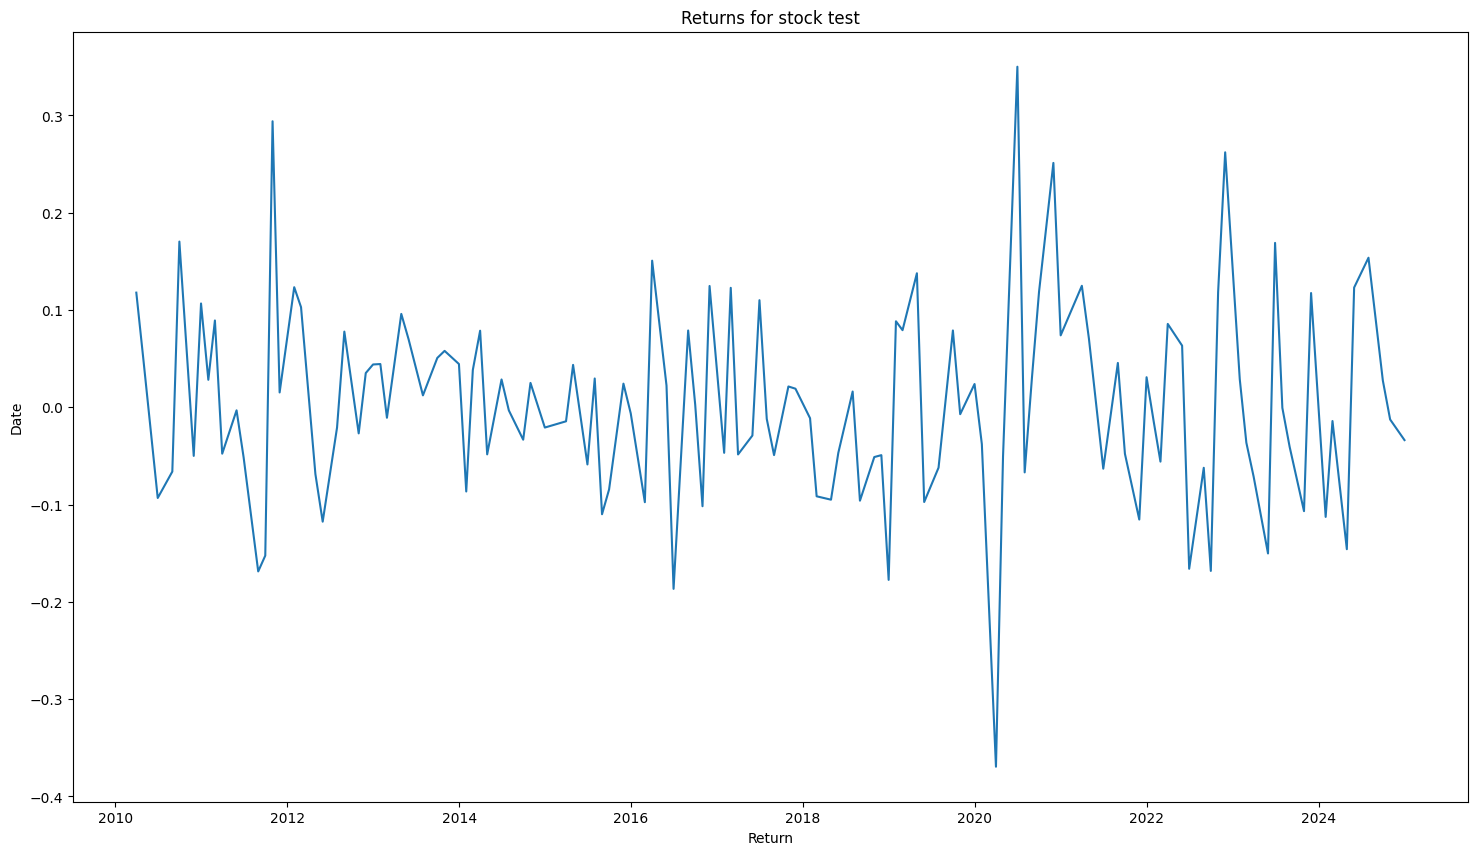

In [123]:
helper.plot_returns(test_df)

In [124]:
feat=['EMA_3', 'EMA_6', 'EMA_12', 'SMA_3', 'SMA_6', 'SMA_12', 'LOWESS', 'cusip', 'MthCalDt', 'MthRet']

In [125]:
# TODO: add/remove elements to keep in function of what we want the model to be able to use / predict + tweak y_feat accordingly
keep=['EMA_3', 'MthRet']
y_feat = 'MthRet'

In [126]:
test_df = keep_selec(test_df, feat, keep)

In [127]:
x = test_df.drop(y_feat, axis =1)
y = test_df[y_feat].values

In [128]:
x.head(2)

,sprtrn,epspxy,epspiy,epsfiy,epsfxy,oiadpy,cshpry,dvy,capxy,sstky,...,chechy,earnings_growth,revenue_growth,net_debt_change,capex_growth,eps_surprise,dividend_change,repurchase_intensity,unified_sentiment,EMA_3
7259,0.058796,0.22,0.22,0.21,0.21,154.1,439.0,44.8,15.5,3.7,...,-165.0,2.094463,0.310791,-48.3,1.924528,-0.55,0.151671,0.0,0.107506,0.047387
7935,0.014759,0.22,0.22,0.21,0.21,154.1,439.0,44.8,15.5,3.7,...,-165.0,2.094463,0.310791,-48.3,1.924528,-0.55,0.151671,0.0,0.048555,0.048340


In [129]:
# TODO: tweak with test_size
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

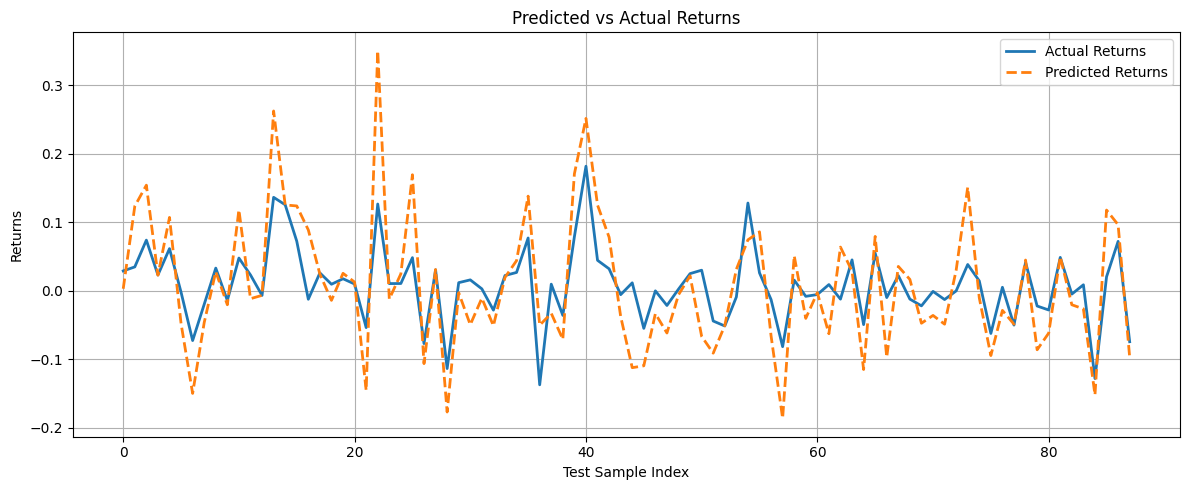

In [130]:
helper.plot_preds_line(x_train['EMA_3'], y_train)

In [131]:
helper.report_metrics(x_train['EMA_3'], y_train, 'Basic_EMA_3')

--- Basic_EMA_3 vs y_true ---
MAE  : 0.04427
RMSE : 0.05857
R²    : 0.63237



In [132]:
# General method that tests most "basic" ml methods available from sklearn packages

from helper import test_ml

# Signature:
# test_ml(x_train, y_train, x_test, y_test, meth, model_kwargs=None, fit_kwargs=None):
"""
    Train, evaluate, and visualize a regression model using provided train/test data.

    This function instantiates a machine learning model using the given constructor,
    fits it on the training data, evaluates it using R² score, plots predicted vs. actual
    values, and returns the predictions and test data.

    Parameters
    ----------
    x_train : array-like or pd.DataFrame
        Training features.

    y_train : array-like or pd.Series
        Training labels/targets.

    x_test : array-like or pd.DataFrame
        Test features.

    y_test : array-like or pd.Series
        Test labels/targets.

    meth : callable
        A model constructor (e.g. XGBRegressor, LinearRegression). Must implement
        `.fit()` and `.predict()` methods.

    model_kwargs : dict, optional
        Keyword arguments to pass to the model constructor (e.g., hyperparameters like
        `n_estimators`, `max_depth`, etc.).

    fit_kwargs : dict, optional
        Keyword arguments to pass to the model's `.fit()` method (e.g., `eval_metric`,
        `sample_weight`, etc.).

    Returns
    -------
    y_p_
"""

"\n    Train, evaluate, and visualize a regression model using provided train/test data.\n\n    This function instantiates a machine learning model using the given constructor,\n    fits it on the training data, evaluates it using R² score, plots predicted vs. actual\n    values, and returns the predictions and test data.\n\n    Parameters\n    ----------\n    x_train : array-like or pd.DataFrame\n        Training features.\n\n    y_train : array-like or pd.Series\n        Training labels/targets.\n\n    x_test : array-like or pd.DataFrame\n        Test features.\n\n    y_test : array-like or pd.Series\n        Test labels/targets.\n\n    meth : callable\n        A model constructor (e.g. XGBRegressor, LinearRegression). Must implement\n        `.fit()` and `.predict()` methods.\n\n    model_kwargs : dict, optional\n        Keyword arguments to pass to the model constructor (e.g., hyperparameters like\n        `n_estimators`, `max_depth`, etc.).\n\n    fit_kwargs : dict, optional\n    

# 1) **XGBoost**

R^2 score:  0.4684304711652708


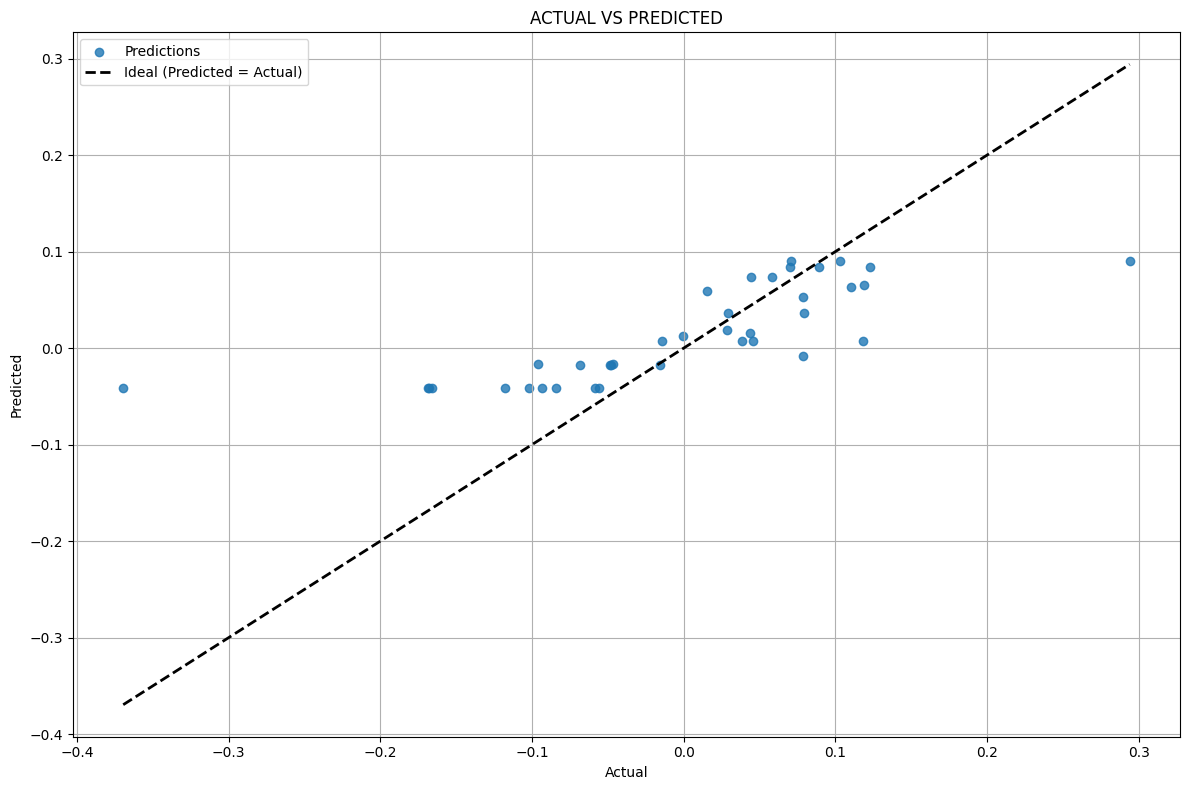

In [133]:
from xgboost import XGBRegressor

model_kwargs={
        'n_estimators': 150,         # Number of boosting rounds
        'max_depth': 4,              # Max tree depth
        'learning_rate': 0.05,       # Step size shrinkage
        'subsample': 0.8,            # Row sampling
        'colsample_bytree': 0.7,     # Feature sampling per tree
        'gamma': 0.1,                # Min loss reduction to split
        'min_child_weight': 1,       # Minimum sum of instance weight in a child
        'reg_alpha': 0.01,           # L1 regularization term
        'reg_lambda': 0.5,           # L2 regularization term
        'booster': 'gbtree',         # Booster type: 'gbtree' | 'gblinear' | 'dart'
        'verbosity': 0,              # Suppress warnings
        'random_state': 42,          # Reproducibility
        'tree_method': 'hist'        # Fast histogram-based training
    }

y_p, y_t, x_t = test_ml(x_train, y_train, x_test, y_test, XGBRegressor, model_kwargs=model_kwargs)

In [134]:
param_grid = {
    'n_estimators': [100, 200],                  # Model complexity
    'max_depth': [3, 5],                         # Under- vs overfitting
    'learning_rate': [0.01, 0.1, 0.5],           # Speed vs stability
    'subsample': [0.7, 0.9],                     # Row sampling
    'colsample_bytree': [0.5, 0.8],              # Feature sampling
    'gamma': [0.1, 0.3],                         # Split penalty
    'reg_alpha': [0.01, 0.1],                    # L1 regularization
    'reg_lambda': [0.5, 1],                      # L2 regularization
    'booster': ['gbtree', 'dart']                # Drop 'gblinear'
}


best_model, best_params, grid_result = helper.tune_hyperparameters(XGBRegressor, param_grid, x_train, y_train)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


In [135]:
print(best_params)

{'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.7}


R^2 score:  0.530357462923376


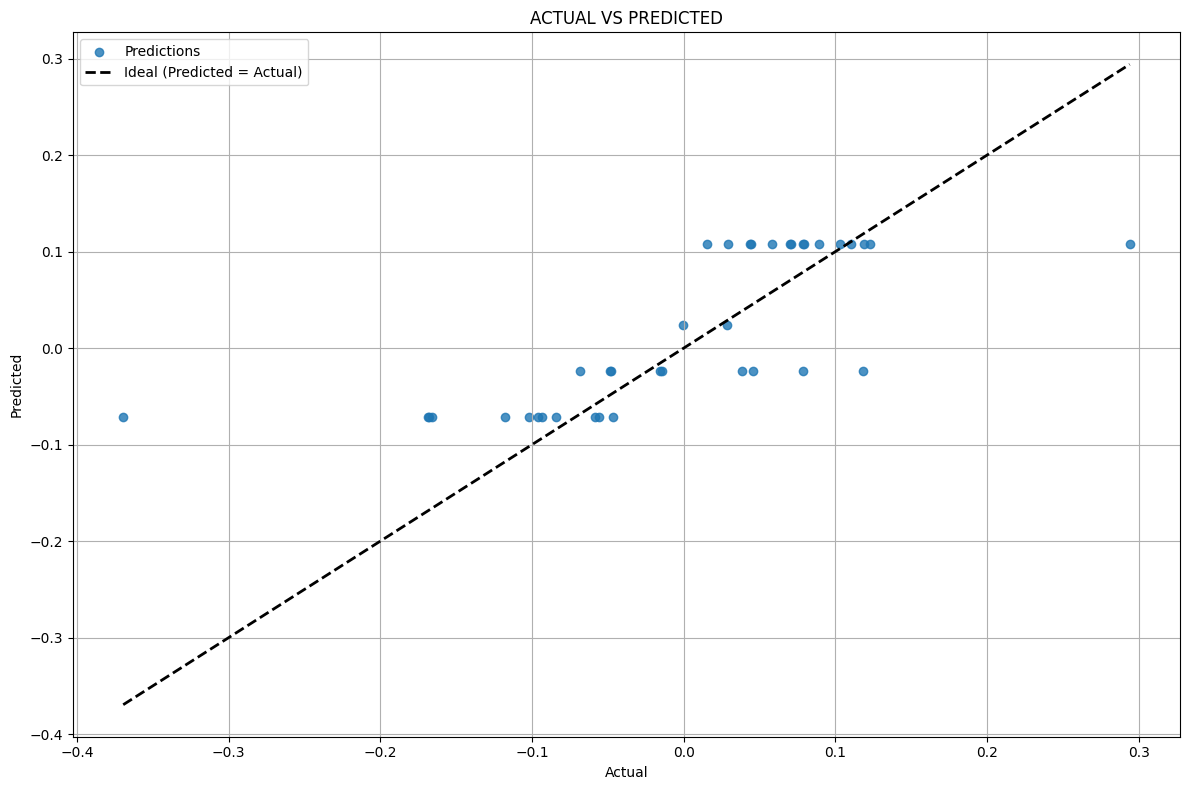

In [136]:
y_p_hs, y_t_hs, x_t_hs = test_ml(x_train, y_train, x_test, y_test, XGBRegressor, model_kwargs=best_params)

In [137]:
y_p

array([ 0.00703134, -0.04105965,  0.00703134, -0.04105965,  0.03663316,
       -0.01616463,  0.08403623,  0.05312053, -0.04105965,  0.0591412 ,
       -0.04105965,  0.03663316,  0.09052438,  0.09052438, -0.01616463,
       -0.04105965,  0.06350615,  0.08403623, -0.04105965,  0.01252748,
        0.08403623,  0.09052438, -0.01786369, -0.04105965, -0.04105965,
       -0.04105965, -0.00803362, -0.01786369,  0.00703134, -0.01786369,
       -0.04105965,  0.0736506 ,  0.0736506 ,  0.06562935,  0.01610307,
       -0.01786369,  0.00703134,  0.01866516], dtype=float32)

In [138]:
y_p_hs

array([-0.02324967, -0.07138002, -0.02324967, -0.07138002,  0.10757084,
       -0.07138002,  0.10757084,  0.10757084, -0.07138002,  0.10757084,
       -0.07138002,  0.10757084,  0.10757084,  0.10757084, -0.07138002,
       -0.07138002,  0.10757084,  0.10757084, -0.07138002,  0.02345745,
        0.10757084,  0.10757084, -0.02324967, -0.07138002, -0.07138002,
       -0.07138002, -0.02324967, -0.02324967, -0.02324967, -0.02324967,
       -0.07138002,  0.10757084,  0.10757084,  0.10757084,  0.10757084,
       -0.02324967, -0.02324967,  0.02345745], dtype=float32)

In [139]:
y_t_hs

array([ 0.118248, -0.093211, -0.014123, -0.101695,  0.07927 , -0.096007,
        0.069925,  0.078717, -0.369444,  0.015249, -0.168185,  0.028905,
        0.070579,  0.102896, -0.046902, -0.168701,  0.110095,  0.089246,
       -0.05875 , -0.000595,  0.12281 ,  0.294004, -0.068616, -0.117549,
       -0.084433, -0.165977,  0.078981, -0.048462,  0.038378, -0.015639,
       -0.055835,  0.044461,  0.057994,  0.118627,  0.044018, -0.04769 ,
        0.045587,  0.02861 ])

In [140]:
helper.report_metrics(y_p, y_t_hs, "y_p")
helper.report_metrics(y_p_hs, y_t_hs, "y_p_hs")

--- y_p vs y_true ---
MAE  : 0.05515
RMSE : 0.08278
R²    : 0.46843

--- y_p_hs vs y_true ---
MAE  : 0.05284
RMSE : 0.07781
R²    : 0.53036



In [141]:
import sklearn
print(sklearn.__version__)


1.7.0


In [142]:
from sklearn.linear_model import LinearRegression
print(LinearRegression().get_params().keys())


dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'positive', 'tol'])


# 2) Linear Regression

Running GridSearchCV for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True, 'tol': 0.01}
R^2 score:  0.8327729356189011


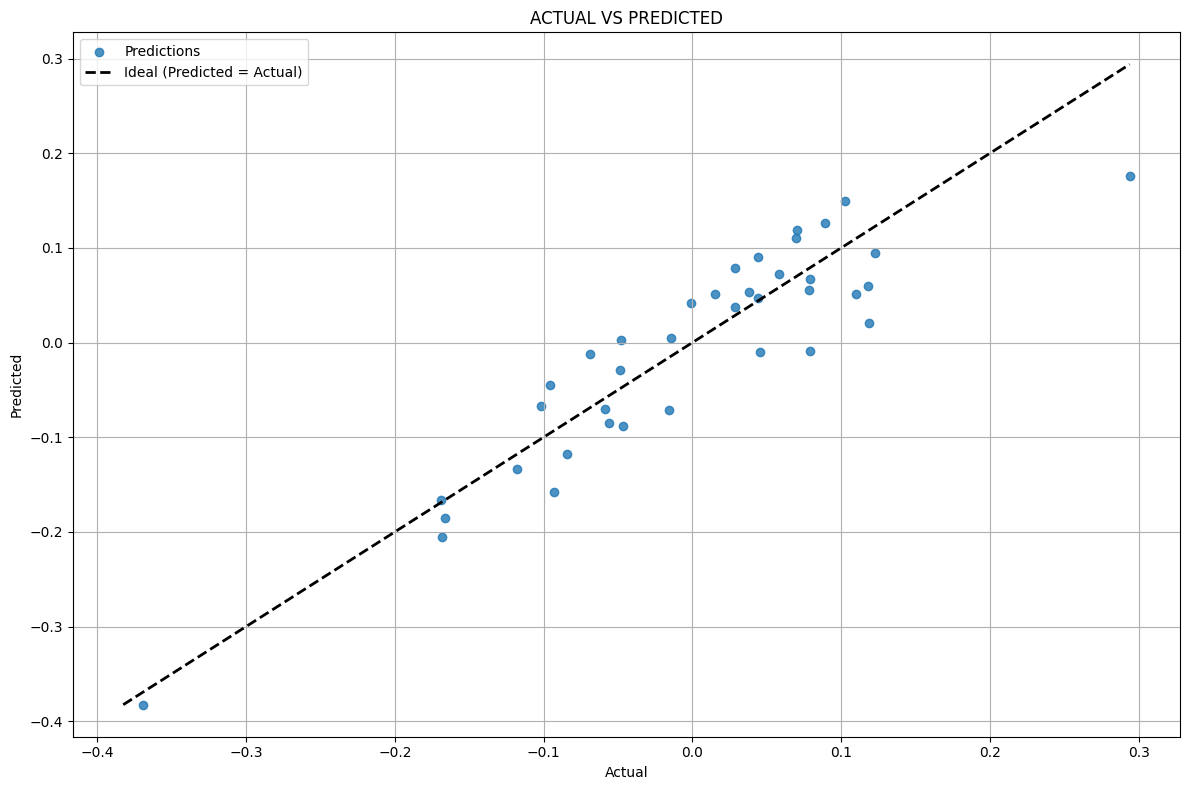


--- Linear Regression ---
--- Linear Regression vs y_true ---
MAE  : 0.03902
RMSE : 0.04643
R²    : 0.83277



(LinearRegression(n_jobs=-1, positive=True, tol=0.01),
 array([ 0.05983153, -0.15757694,  0.00493648, -0.06748643,  0.06752499,
        -0.04490915,  0.11021799,  0.05587309, -0.38257618,  0.05188897,
        -0.20574826,  0.07888027,  0.11945132,  0.149725  , -0.08840264,
        -0.16679725,  0.05126452,  0.12594888, -0.06973764,  0.04209175,
         0.09477574,  0.17645716, -0.01243988, -0.1333667 , -0.1175665 ,
        -0.18527238, -0.00931634, -0.02896297,  0.0532096 , -0.07148988,
        -0.0848618 ,  0.09080971,  0.07295124,  0.02079688,  0.04750199,
         0.00230909, -0.00988347,  0.03795528]),
 array([ 0.118248, -0.093211, -0.014123, -0.101695,  0.07927 , -0.096007,
         0.069925,  0.078717, -0.369444,  0.015249, -0.168185,  0.028905,
         0.070579,  0.102896, -0.046902, -0.168701,  0.110095,  0.089246,
        -0.05875 , -0.000595,  0.12281 ,  0.294004, -0.068616, -0.117549,
        -0.084433, -0.165977,  0.078981, -0.048462,  0.038378, -0.015639,
        -0.0558

In [143]:
from sklearn.linear_model import LinearRegression

param_grid = {
    'fit_intercept': [True],   # Learn an intercept (default = True)
    'copy_X': [True],          # Safe to copy, avoids overwriting original data
    'n_jobs': [-1],            # Use all CPU cores for fitting
    'positive': [False, True], # Allow negative coefficients
    'tol': [1e-2, 1e-4, 1e-6, 1e-8]   # Tolerance for stopping criteria
}
helper.full_model_pipeline(LinearRegression, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='Linear Regression')

# 3) ElasticNet

Running GridSearchCV for ElasticNet...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 1000, 'positive': False, 'precompute': False, 'selection': 'random', 'tol': 0.001, 'warm_start': False}
R^2 score:  -0.0756427127821977


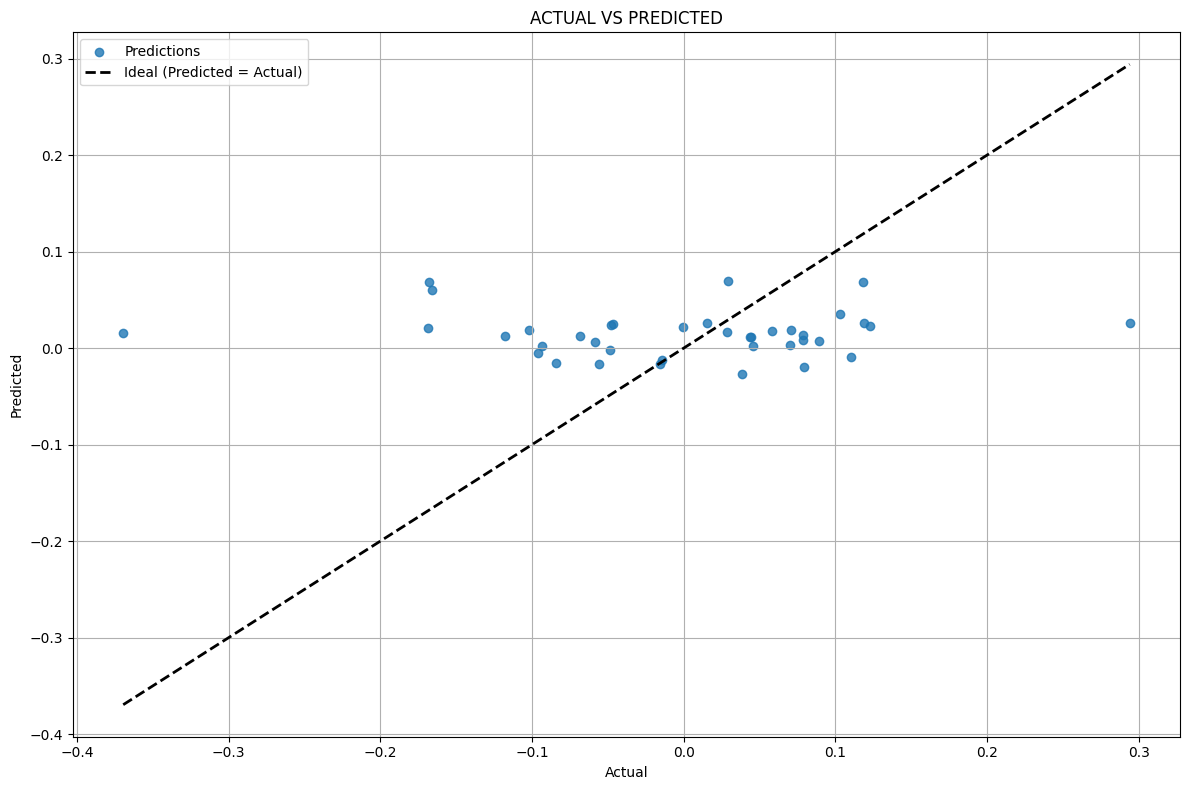


--- ElasticNet ---
--- ElasticNet vs y_true ---
MAE  : 0.08828
RMSE : 0.11776
R²    : -0.07564



In [144]:
from sklearn.linear_model import ElasticNet

param_grid = {
    'alpha': [0.01, 0.1, 1.0],              # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.9],            # L1 vs L2 ratio
    'fit_intercept': [True],
    'precompute': [False],                 # Can be set to True if X.T @ X is reused
    'max_iter': [1000],
    'copy_X': [True],
    'tol': [1e-3, 1e-4],                   # Solver tolerance
    'warm_start': [False],
    'positive': [False],
    'selection': ['cyclic', 'random']
}


best_model, y_pred, y_t = helper.full_model_pipeline(
    model_class=ElasticNet,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid=param_grid,
    grid_search=True,
    model_name='ElasticNet'
)

## We see that these results are very disappointing, let's try to look into the feature's importance:

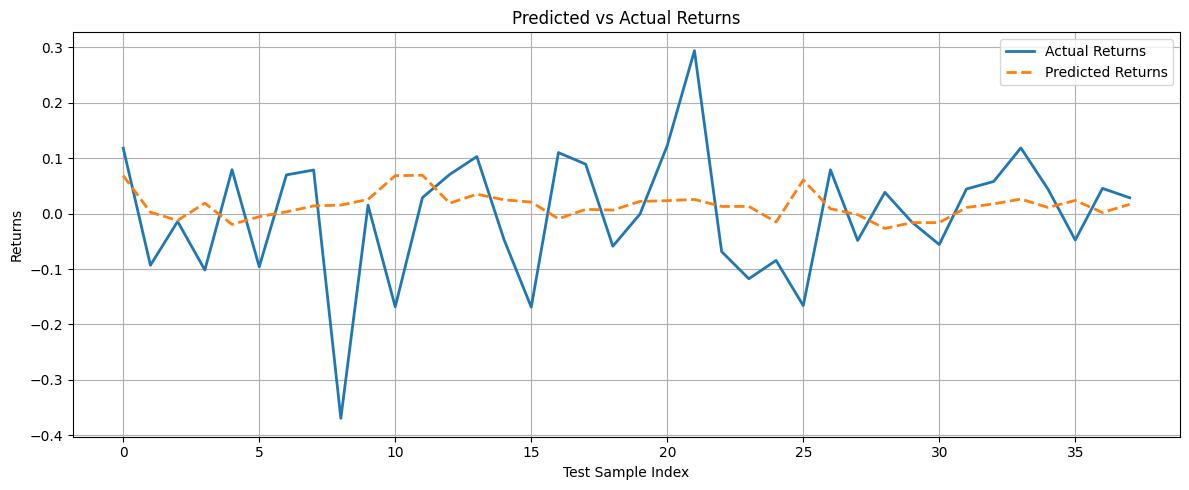

In [145]:
helper.plot_preds_line(y_test, y_pred)

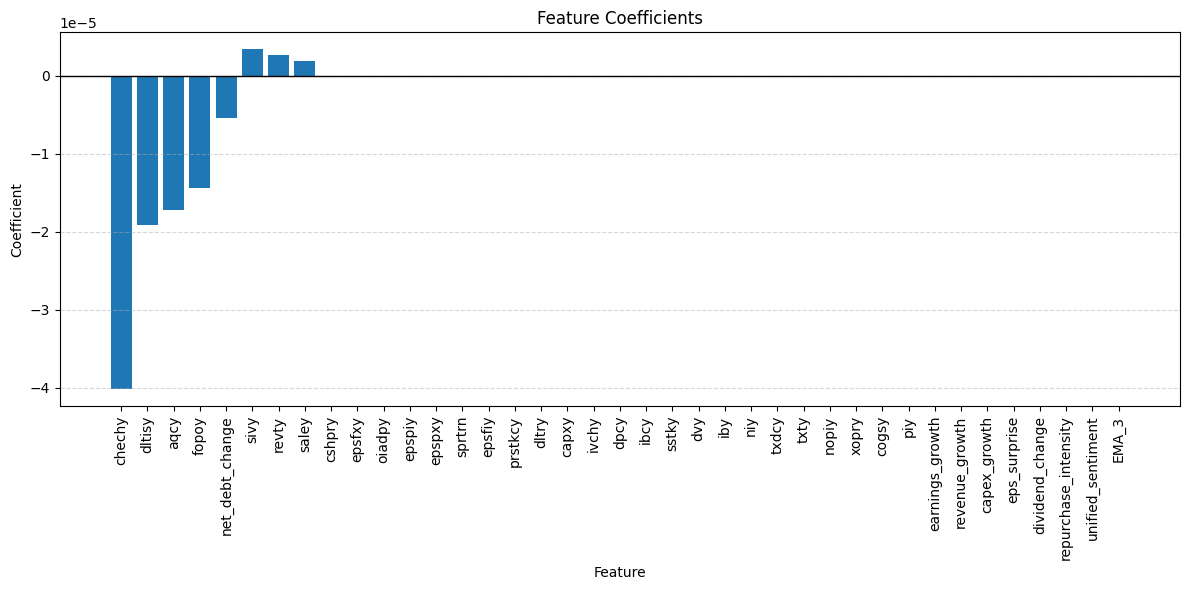

                 Feature  Importance
29                chechy   -0.000040
13                dltisy   -0.000019
10                  aqcy   -0.000017
17                 fopoy   -0.000014
32       net_debt_change   -0.000005
14                  sivy    0.000003
22                 revty    0.000003
20                 saley    0.000002
6                 cshpry    0.000000
4                 epsfxy   -0.000000
5                 oiadpy    0.000000
2                 epspiy   -0.000000
1                 epspxy   -0.000000
0                 sprtrn    0.000000
3                 epsfiy   -0.000000
11               prstkcy   -0.000000
12                 dltry    0.000000
8                  capxy   -0.000000
15                 ivchy   -0.000000
18                  dpcy    0.000000
16                  ibcy   -0.000000
9                  sstky    0.000000
7                    dvy    0.000000
21                   iby   -0.000000
19                   niy   -0.000000
25                 txdcy    0.000000
2

In [146]:
helper.feat_analysis(x_train, y_train, best_model)

## Explanation:
I’m thinking the features are probably already pretty clean like they’re not super correlated and they were chosen reasonably well thus applying regularization was actually holding the model back.
It was being too cautious. But once I removed it by setting alpha = 0, ElasticNet started acting like LinearRegression, and suddenly the fit got way better. Makes sense in hindsight.

Running GridSearchCV for ElasticNet...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:
{'alpha': 0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 1000, 'positive': False, 'precompute': False, 'selection': 'random', 'tol': 0.001, 'warm_start': False}
R^2 score:  0.755014269462203


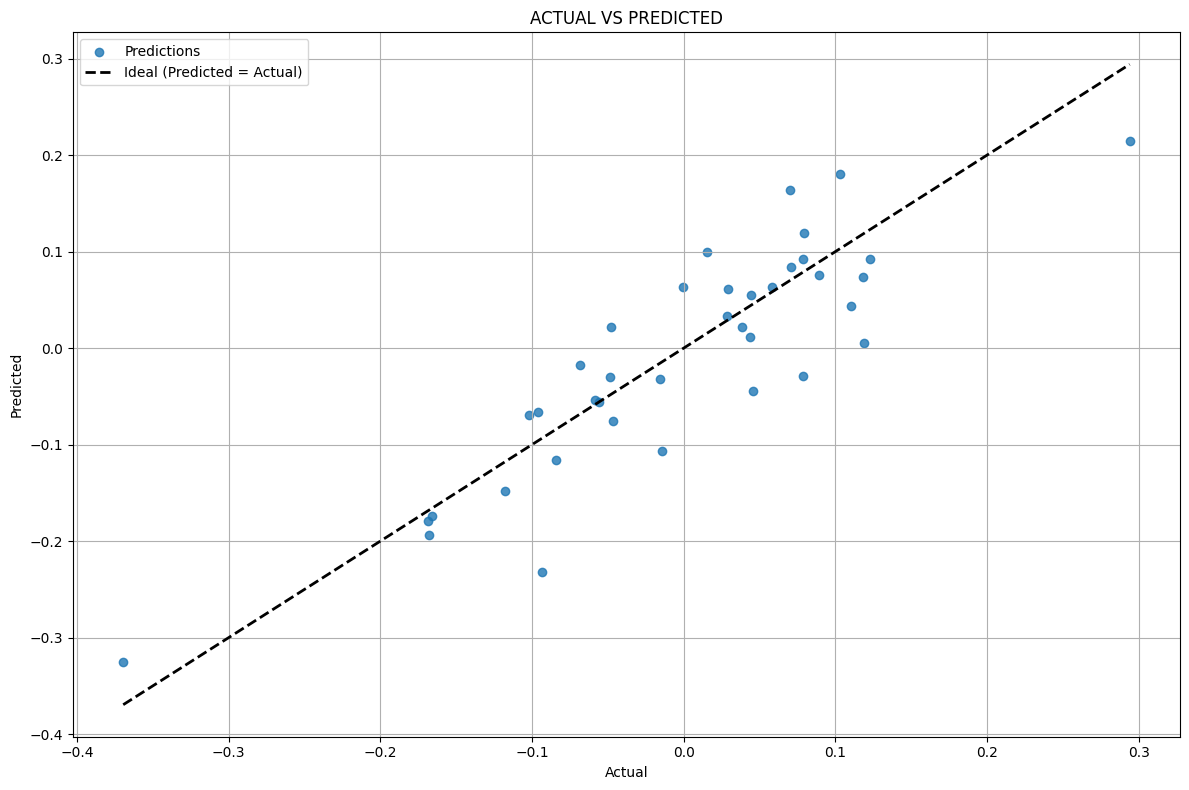


--- ElasticNet ---
--- ElasticNet vs y_true ---
MAE  : 0.04384
RMSE : 0.05620
R²    : 0.75501



In [147]:
from sklearn.linear_model import ElasticNet

param_grid = {
    'alpha': [0],              # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.9],            # L1 vs L2 ratio
    'fit_intercept': [True],
    'precompute': [False],                 # Can be set to True if X.T @ X is reused
    'max_iter': [1000],
    'copy_X': [True],
    'tol': [1e-3, 1e-4],                   # Solver tolerance
    'warm_start': [False],
    'positive': [False],
    'selection': ['cyclic', 'random']
}


best_model, y_pred, y_t = helper.full_model_pipeline(
    model_class=ElasticNet,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid=param_grid,
    grid_search=True,
    model_name='ElasticNet'
)

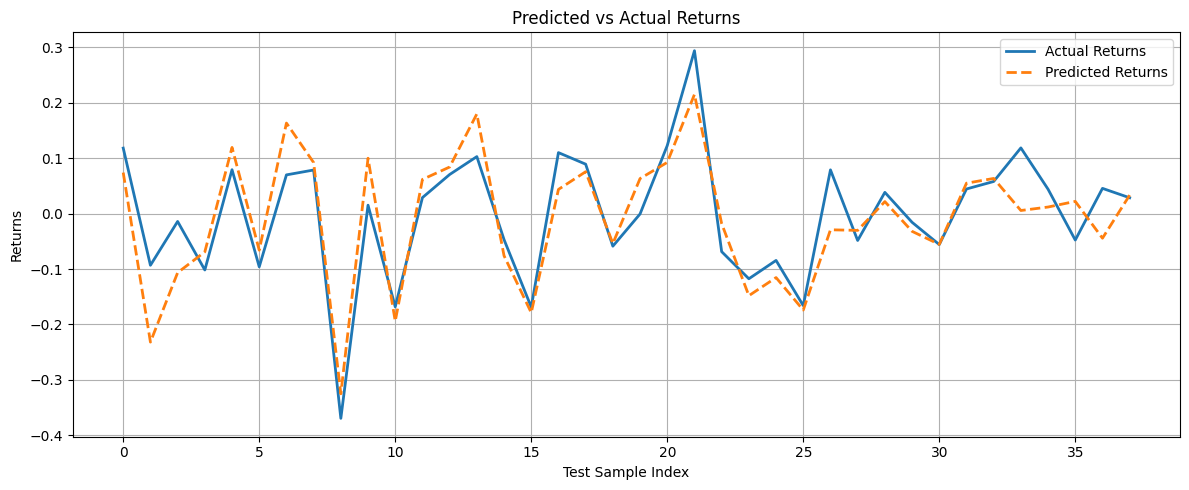

In [148]:
helper.plot_preds_line(y_test, y_pred)

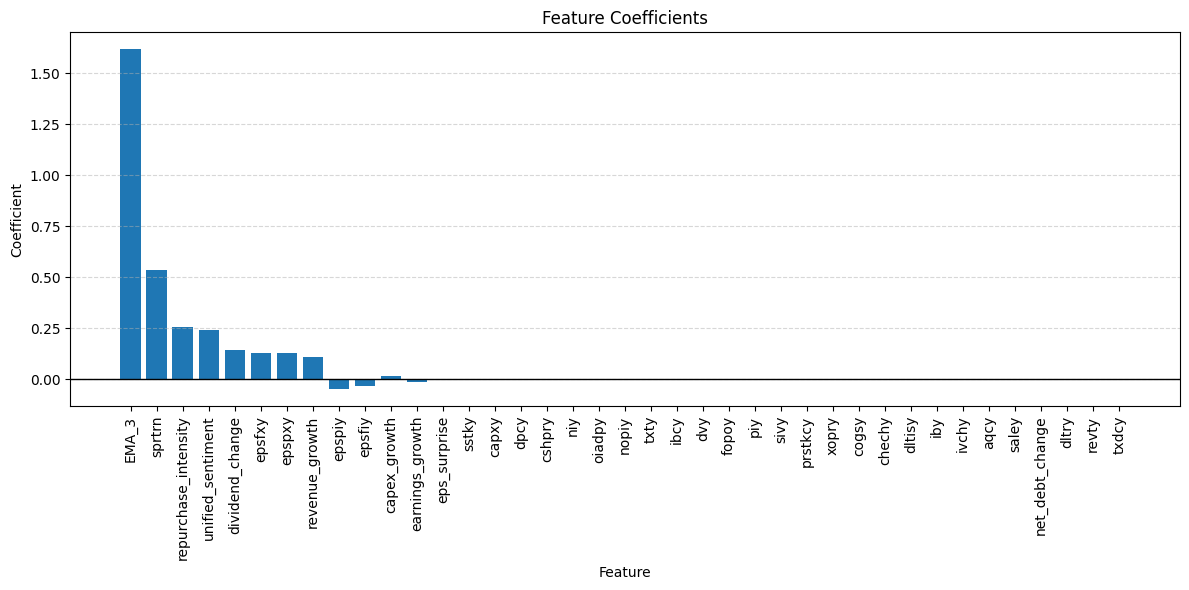

                 Feature    Importance
38                 EMA_3  1.616270e+00
0                 sprtrn  5.371870e-01
36  repurchase_intensity  2.585626e-01
37     unified_sentiment  2.397372e-01
35       dividend_change  1.453952e-01
4                 epsfxy  1.297737e-01
1                 epspxy  1.277367e-01
31        revenue_growth  1.075233e-01
2                 epspiy -4.613110e-02
3                 epsfiy -3.422435e-02
33          capex_growth  1.720394e-02
30       earnings_growth -1.278818e-02
34          eps_surprise -4.385292e-03
9                  sstky -2.129888e-03
8                  capxy -1.421967e-03
18                  dpcy  1.228543e-03
6                 cshpry -5.001317e-04
19                   niy -3.782424e-04
5                 oiadpy -2.640371e-04
26                 nopiy -2.456453e-04
23                  txty  2.343116e-04
16                  ibcy  1.604134e-04
7                    dvy -1.547710e-04
17                 fopoy  1.352836e-04
24                   piy 

In [149]:
helper.feat_analysis(x_train, y_train, best_model)

# 4) RandomForestRegressor

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
R^2 score:  0.4283863055446694


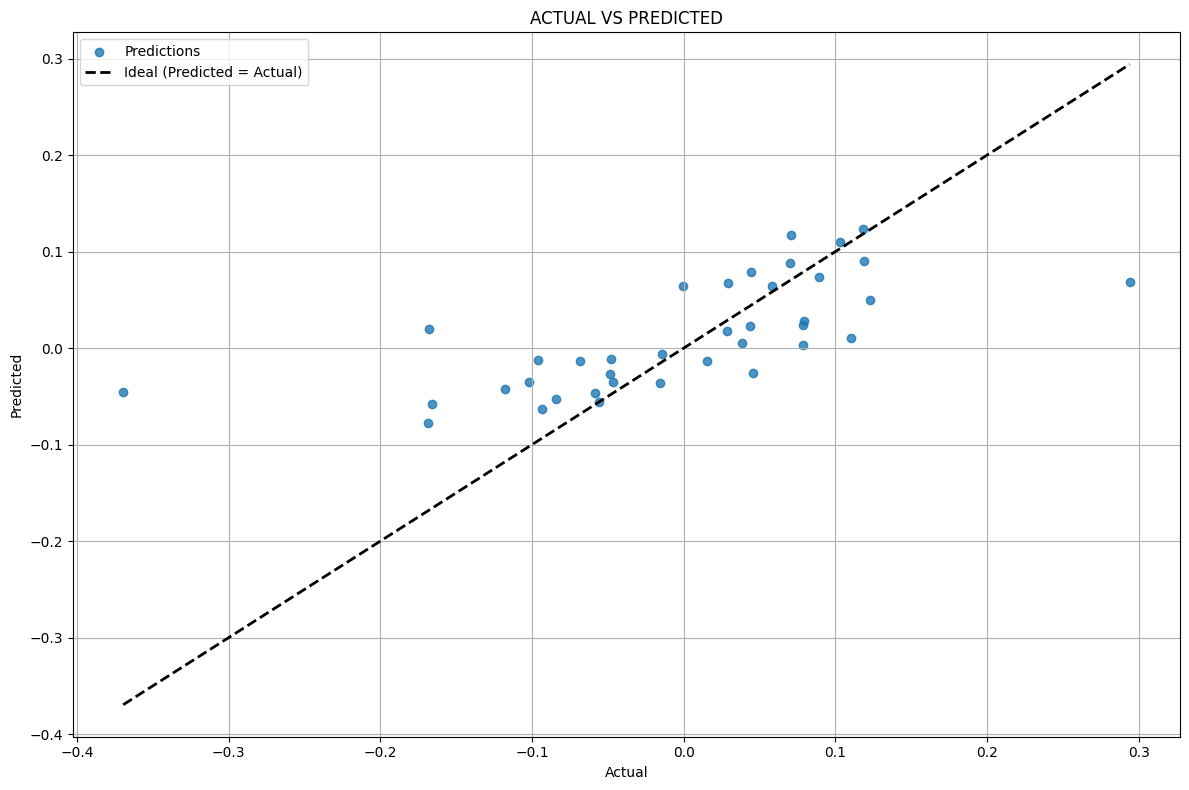


--- Random Forest ---
--- Random Forest vs y_true ---
MAE  : 0.05717
RMSE : 0.08584
R²    : 0.42839



In [150]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['auto', 'sqrt'],
    'random_state': [42]
}

best_model, y_pred, y_t = helper.full_model_pipeline(RandomForestRegressor, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='Random Forest')


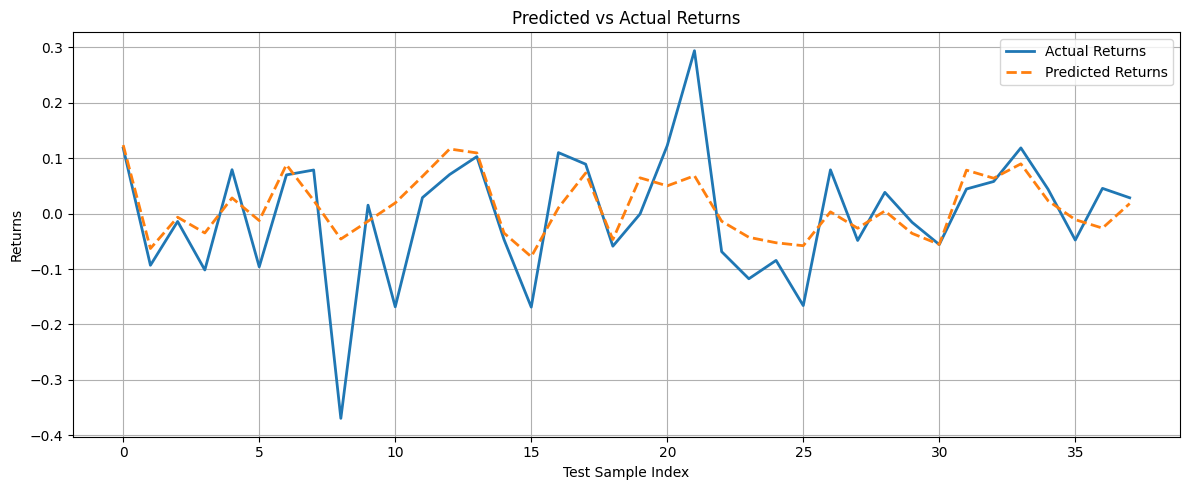

In [151]:
helper.plot_preds_line(y_test, y_pred)

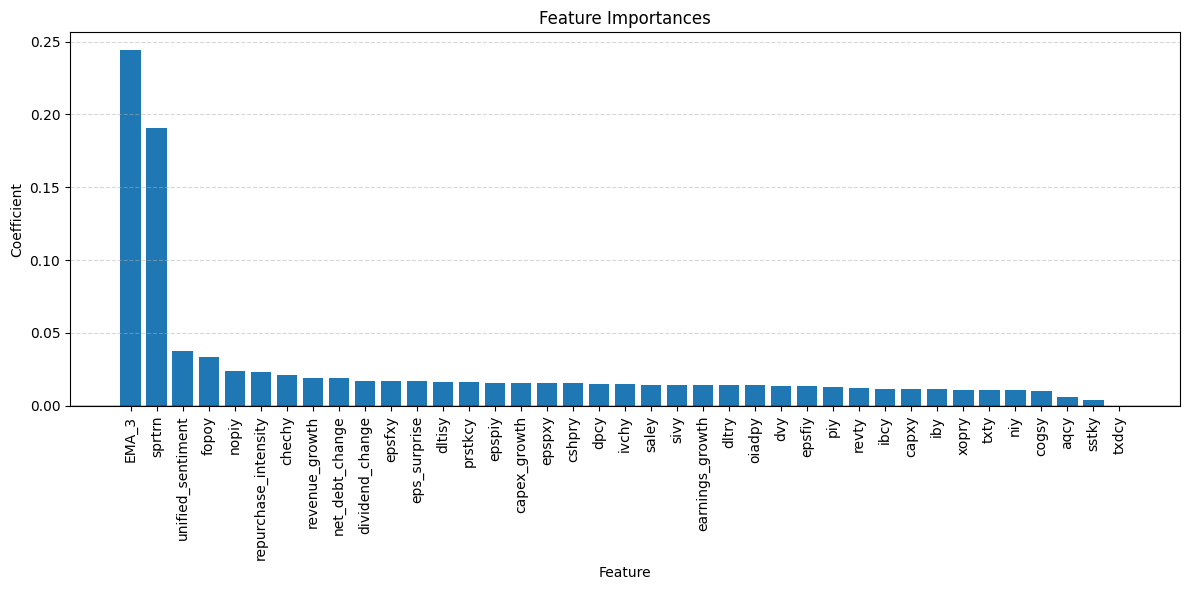

                 Feature  Importance
38                 EMA_3    0.244103
0                 sprtrn    0.190627
37     unified_sentiment    0.037599
17                 fopoy    0.033834
26                 nopiy    0.024215
36  repurchase_intensity    0.023447
29                chechy    0.021387
31        revenue_growth    0.019208
32       net_debt_change    0.019061
35       dividend_change    0.017139
4                 epsfxy    0.016736
34          eps_surprise    0.016721
13                dltisy    0.016575
11               prstkcy    0.016212
2                 epspiy    0.015985
33          capex_growth    0.015768
1                 epspxy    0.015377
6                 cshpry    0.015361
18                  dpcy    0.014900
15                 ivchy    0.014839
20                 saley    0.014508
14                  sivy    0.014227
30       earnings_growth    0.014184
12                 dltry    0.014180
5                 oiadpy    0.014172
7                    dvy    0.013914
3

In [152]:
helper.feat_analysis(x_train, y_train, best_model)

# 5) GradientBoostingRegressor

Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}
R^2 score:  0.6815394677018727


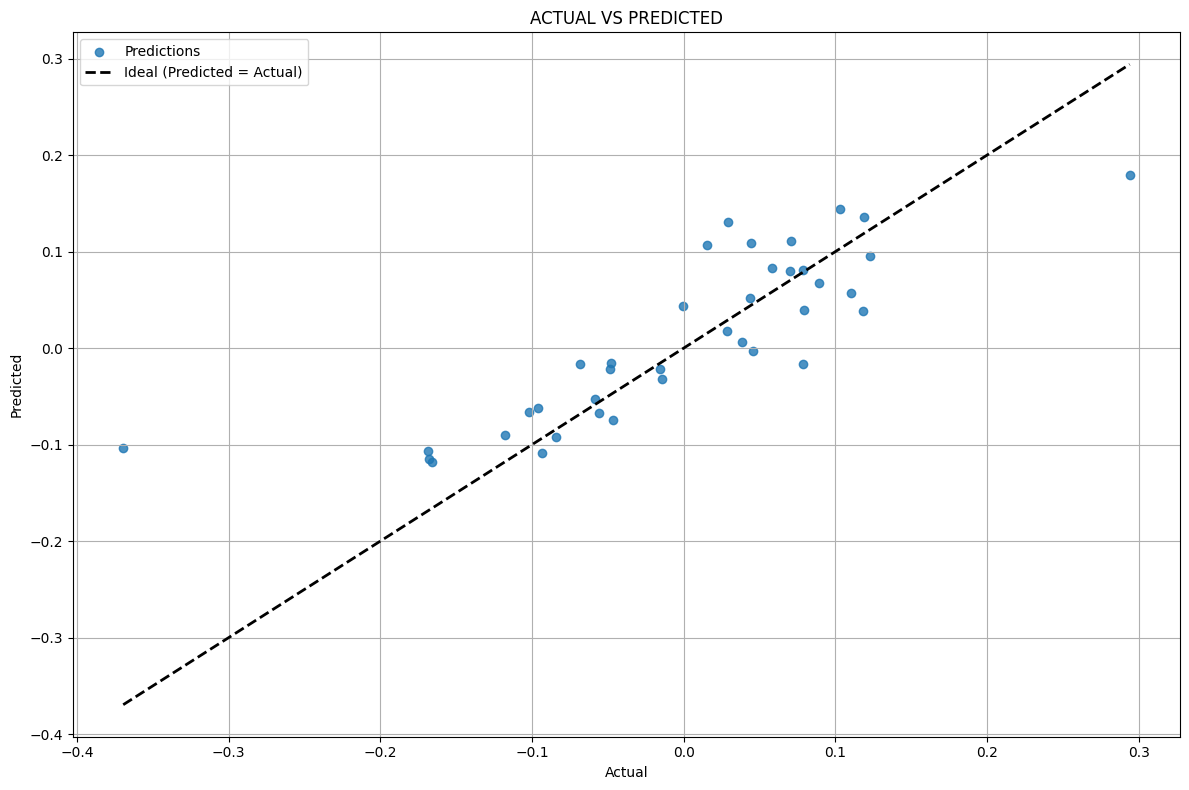


--- Gradient Boosting ---
--- Gradient Boosting vs y_true ---
MAE  : 0.04470
RMSE : 0.06407
R²    : 0.68154



In [153]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'random_state': [42]
}

best_model, y_pred, y_t = helper.full_model_pipeline(GradientBoostingRegressor, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='Gradient Boosting')


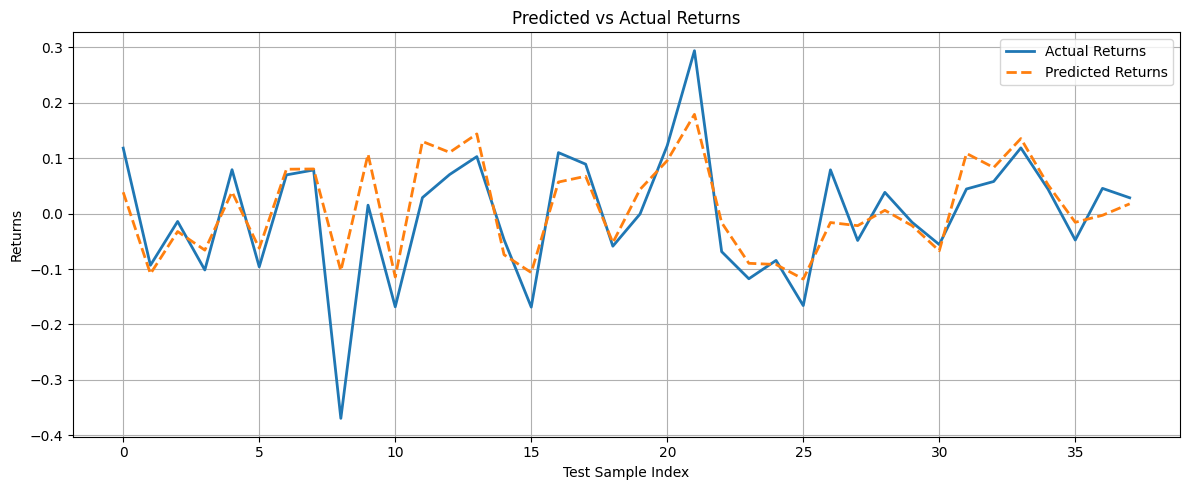

In [154]:
helper.plot_preds_line(y_test, y_pred)

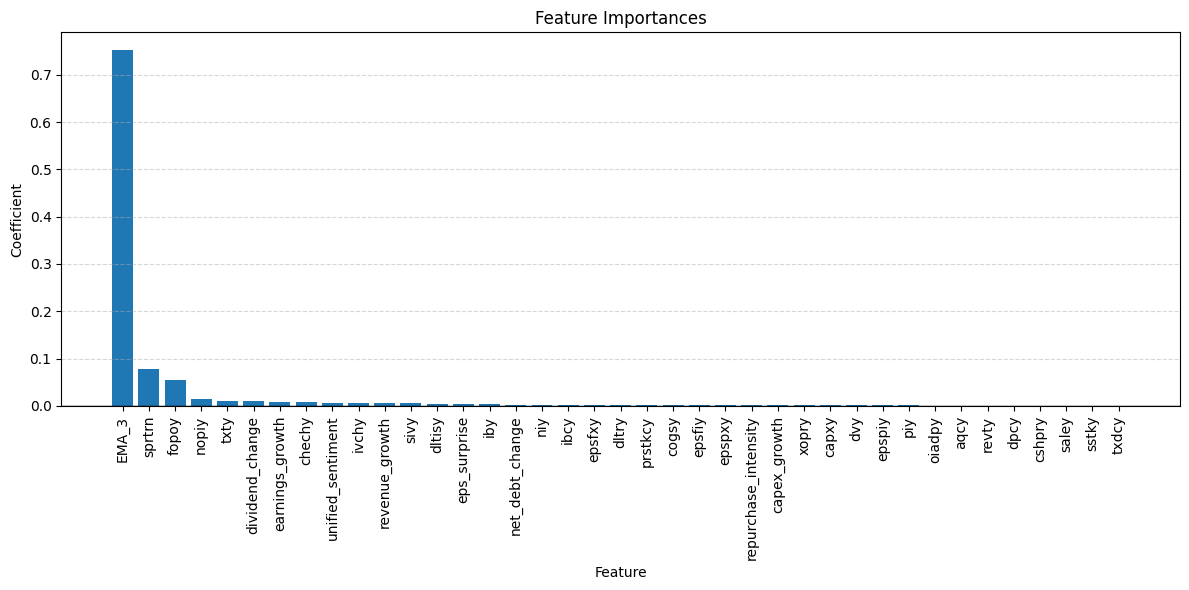

                 Feature  Importance
38                 EMA_3    0.751996
0                 sprtrn    0.077708
17                 fopoy    0.053833
26                 nopiy    0.013865
23                  txty    0.010968
35       dividend_change    0.009745
30       earnings_growth    0.009184
29                chechy    0.007427
37     unified_sentiment    0.006867
15                 ivchy    0.006533
31        revenue_growth    0.005964
14                  sivy    0.005106
13                dltisy    0.004486
34          eps_surprise    0.003380
21                   iby    0.003001
32       net_debt_change    0.002671
19                   niy    0.002595
16                  ibcy    0.002428
4                 epsfxy    0.002116
12                 dltry    0.002104
11               prstkcy    0.002084
28                 cogsy    0.001784
3                 epsfiy    0.001747
1                 epspxy    0.001613
36  repurchase_intensity    0.001516
33          capex_growth    0.001461
2

In [155]:
helper.feat_analysis(x_train, y_train, best_model)

# 6) HuberRegressor

In [172]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Running GridSearchCV for Huber Regressor...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:
{'alpha': 0.001, 'epsilon': 1.5, 'fit_intercept': True}
R^2 score:  -0.18563463321817153


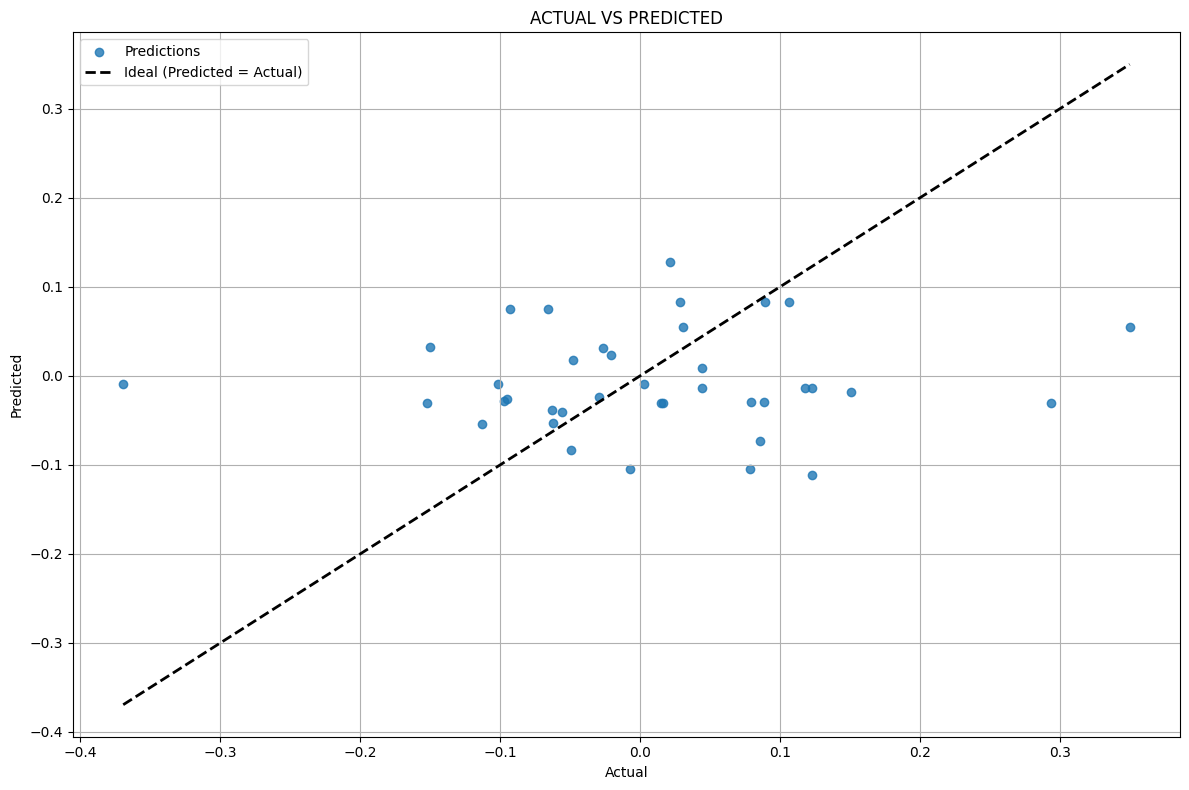


--- Huber Regressor ---
--- Huber Regressor vs y_true ---
MAE  : 0.10235
RMSE : 0.13475
R²    : -0.18563



In [173]:
from sklearn.linear_model import HuberRegressor

param_grid = {
    'epsilon': [1.1, 1.35, 1.5],
    'alpha': [0.0001, 0.001, 0.01],
    'fit_intercept': [True]
}

best_model, y_pred, y_t = helper.full_model_pipeline(HuberRegressor, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='Huber Regressor')

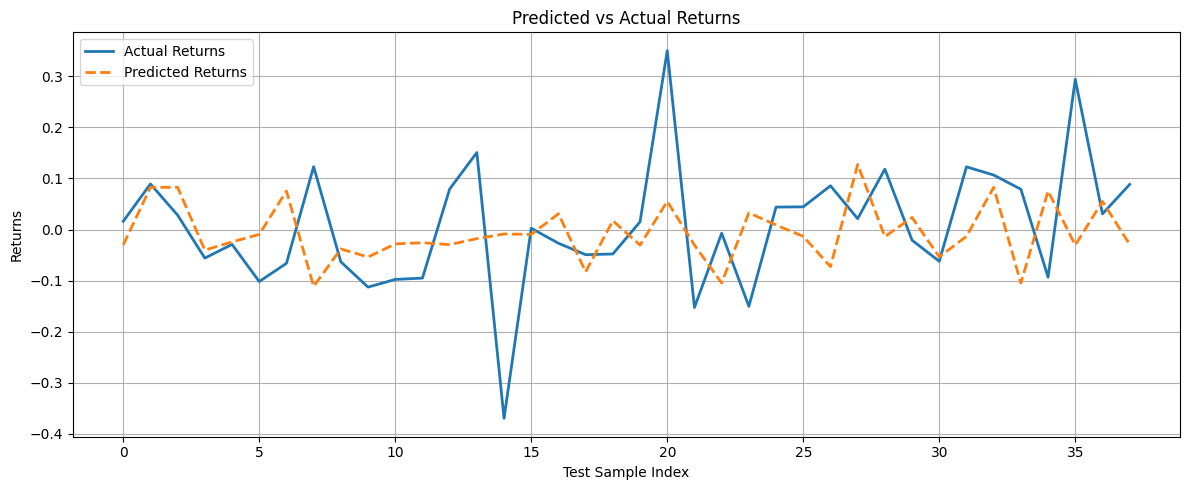

In [174]:
helper.plot_preds_line(y_test, y_pred)

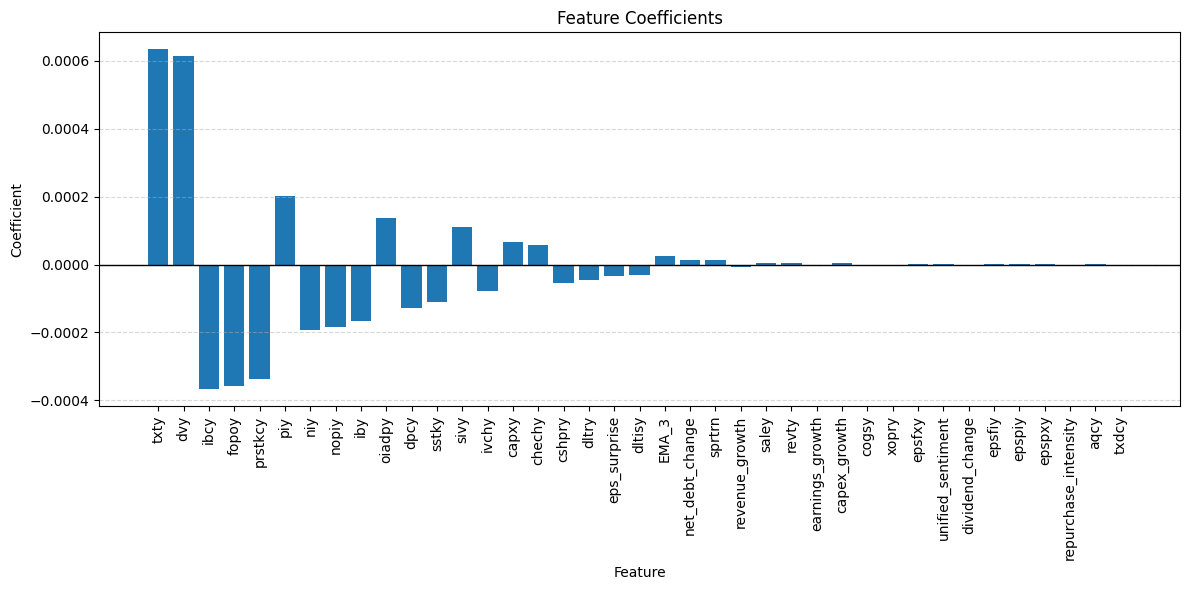

                 Feature    Importance
23                  txty  6.344461e-04
7                    dvy  6.136968e-04
16                  ibcy -3.663438e-04
17                 fopoy -3.580031e-04
11               prstkcy -3.366068e-04
24                   piy  2.035331e-04
19                   niy -1.938193e-04
26                 nopiy -1.846478e-04
21                   iby -1.666809e-04
5                 oiadpy  1.363200e-04
18                  dpcy -1.285671e-04
9                  sstky -1.100631e-04
14                  sivy  1.094552e-04
15                 ivchy -7.786520e-05
8                  capxy  6.758796e-05
29                chechy  5.804159e-05
6                 cshpry -5.301851e-05
12                 dltry -4.594415e-05
34          eps_surprise -3.444873e-05
13                dltisy -3.144507e-05
38                 EMA_3  2.514465e-05
32       net_debt_change  1.449908e-05
0                 sprtrn  1.397747e-05
31        revenue_growth -7.575879e-06
20                 saley 

In [175]:
helper.feat_analysis(x_train, y_train, best_model)

# 7) Support Vector Regression (SVR)

Running GridSearchCV for SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:
{'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
R^2 score:  0.0015148958721026284


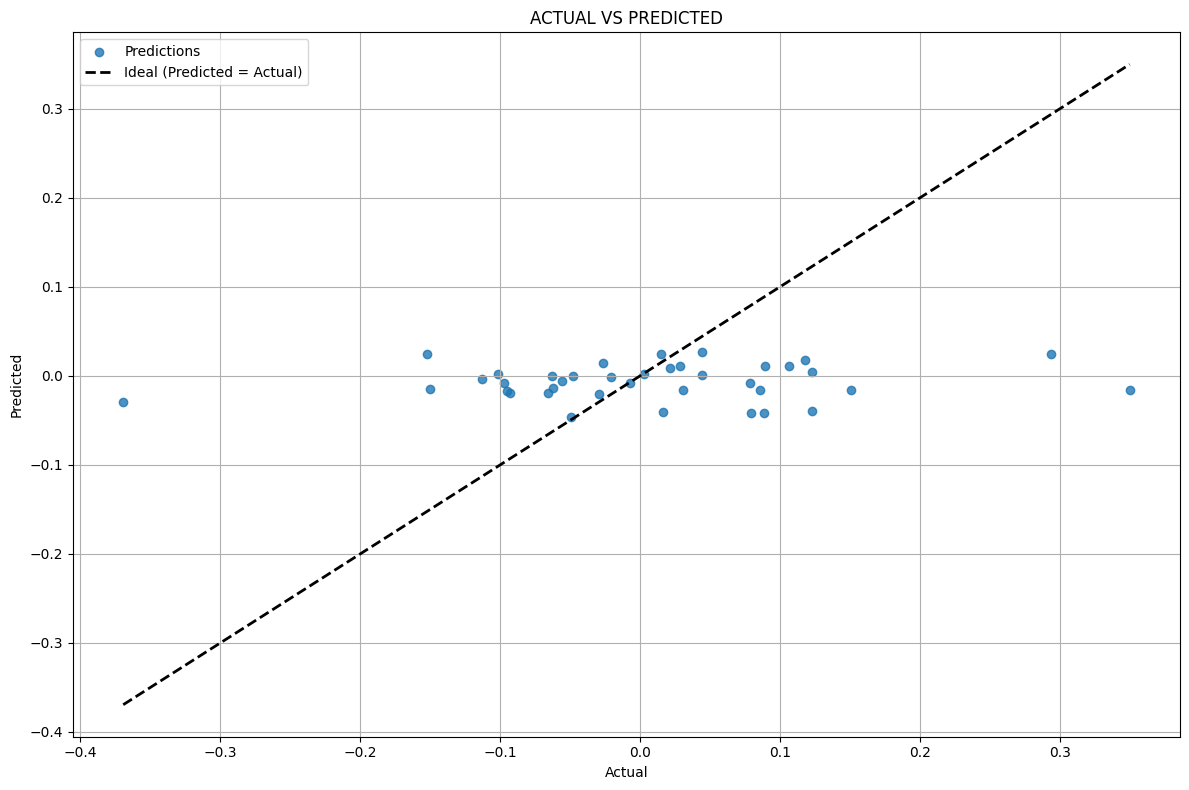


--- SVR ---
--- SVR vs y_true ---
MAE  : 0.09045
RMSE : 0.12366
R²    : 0.00151



In [176]:
from sklearn.svm import SVR

param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1.0, 10],
    'gamma': ['scale', 0.01, 0.1],
    'epsilon': [0.01, 0.1]
}

best_model, y_pred, y_t = helper.full_model_pipeline(SVR, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='SVR')

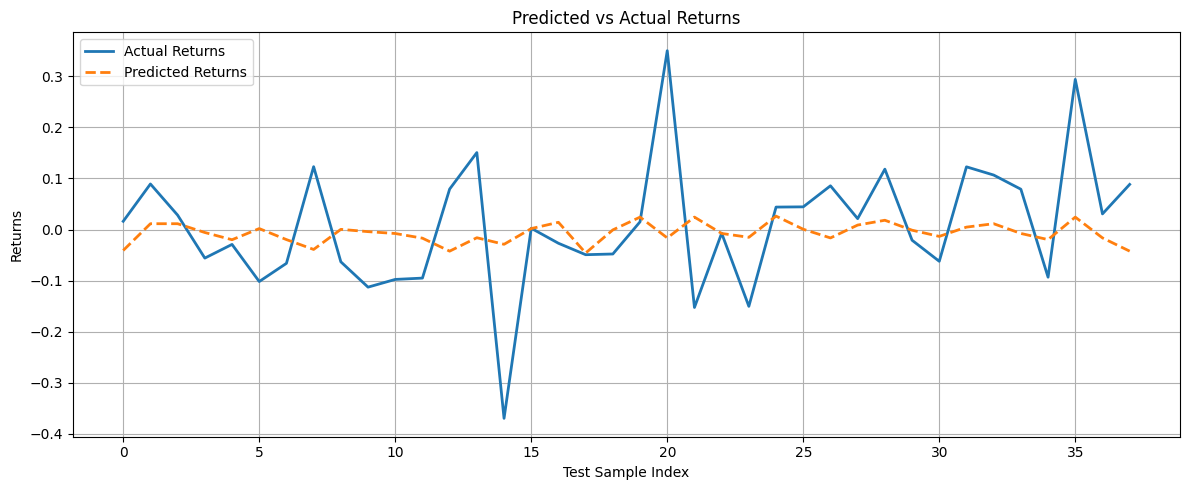

In [177]:
helper.plot_preds_line(y_test, y_pred)

In [178]:
helper.feat_analysis(x_train, y_train, best_model)

⚠️ Model SVR does not expose feature importance.


# 8) KNeighborsRegressor

Running GridSearchCV for KNN Regressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:
{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
R^2 score:  -0.02334090813438361


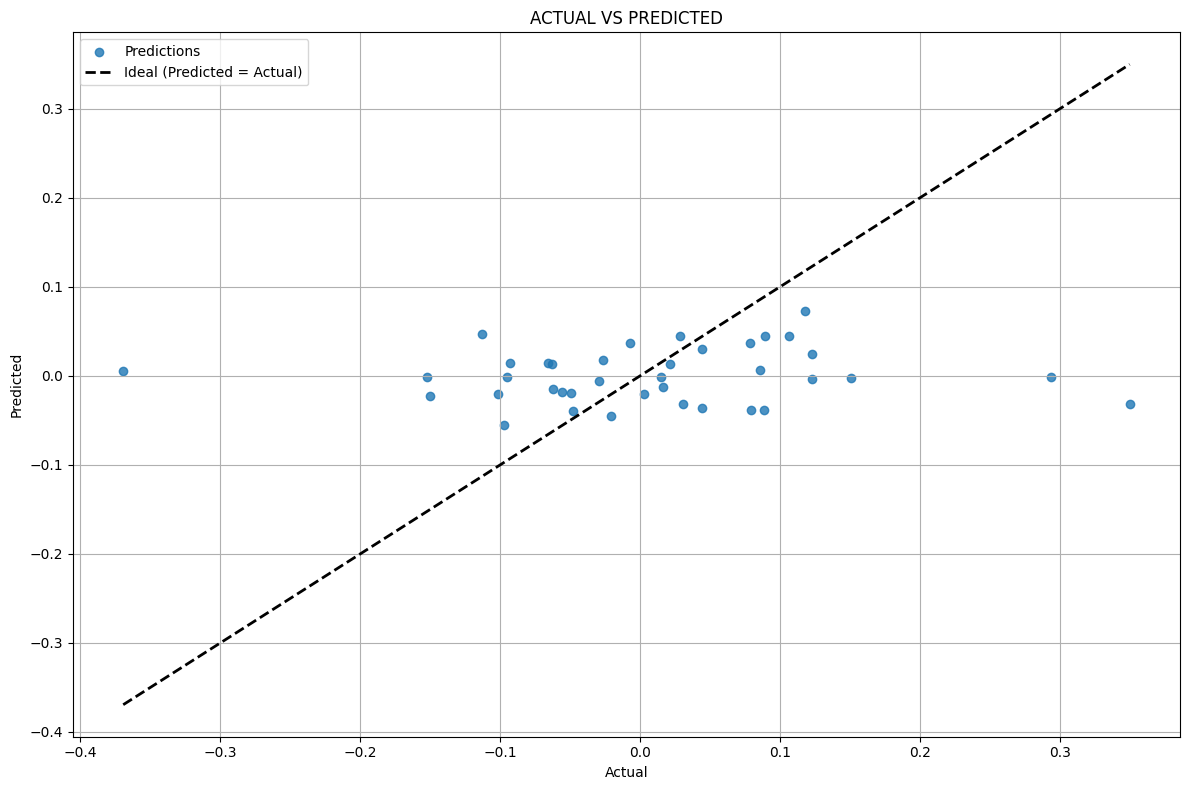


--- KNN Regressor ---
--- KNN Regressor vs y_true ---
MAE  : 0.08881
RMSE : 0.12519
R²    : -0.02334



In [179]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan vs Euclidean
}
best_model, y_pred, y_t = helper.full_model_pipeline(KNeighborsRegressor, x_train, y_train, x_test, y_test, param_grid=param_grid, model_name='KNN Regressor')

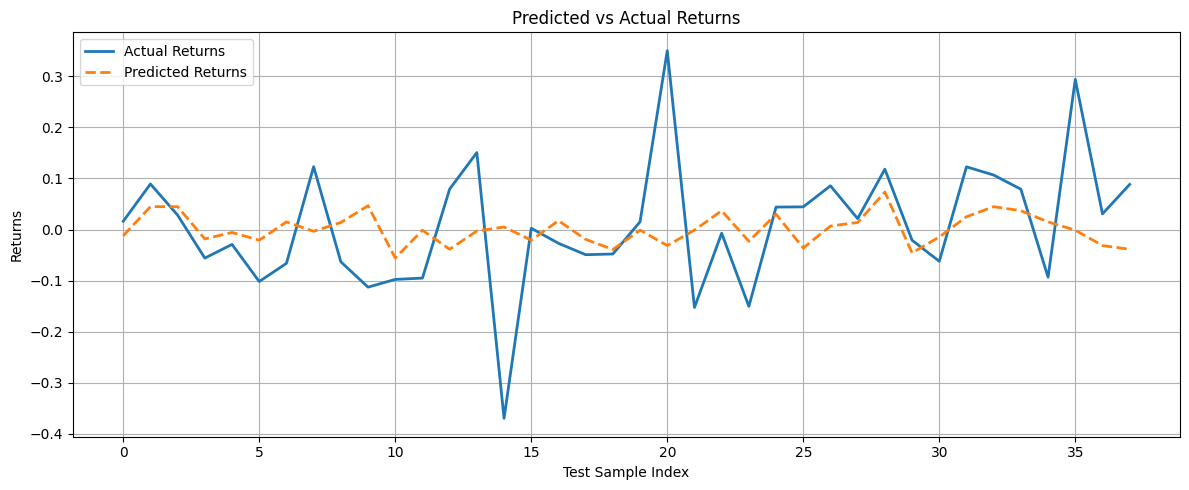

In [180]:
helper.plot_preds_line(y_test, y_pred)

In [181]:
helper.feat_analysis(x_train, y_train, best_model)

⚠️ Model KNeighborsRegressor does not expose feature importance.


# 9) HistGradientBoostingRegressor

Running GridSearchCV for HistGradientBoosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:
{'early_stopping': True, 'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 100, 'random_state': 42}
R^2 score:  0.5491836333850639


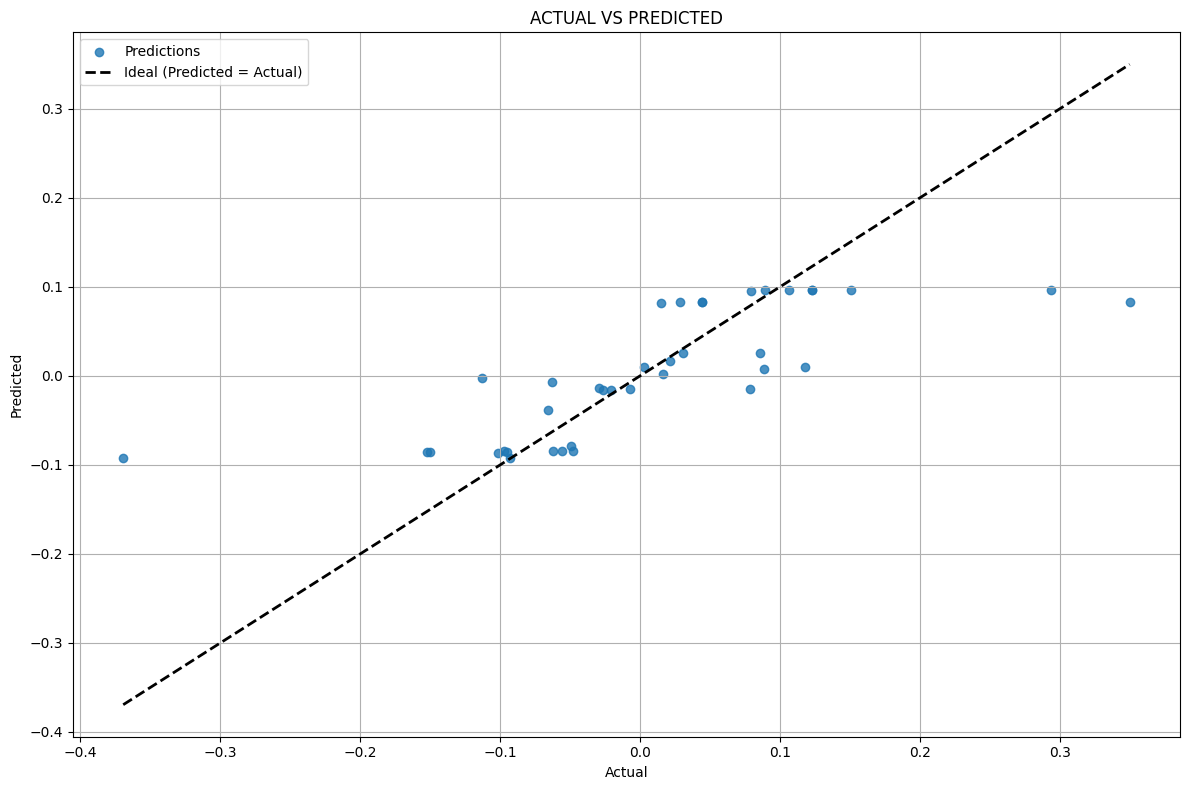


--- HistGradientBoosting ---
--- HistGradientBoosting vs y_true ---
MAE  : 0.05195
RMSE : 0.08309
R²    : 0.54918



In [182]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Define parameter grid to explore
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [3, 5, None],
    'l2_regularization': [0.0, 0.1, 1.0],
    'early_stopping': [True],  # Use early stopping to regularize
    'random_state': [42],
}

# Run the model through your helper pipeline
best_model, y_pred, y_t = helper.full_model_pipeline(
    HistGradientBoostingRegressor,
    x_train, y_train,
    x_test, y_test,
    param_grid=param_grid,
    model_name="HistGradientBoosting"
)


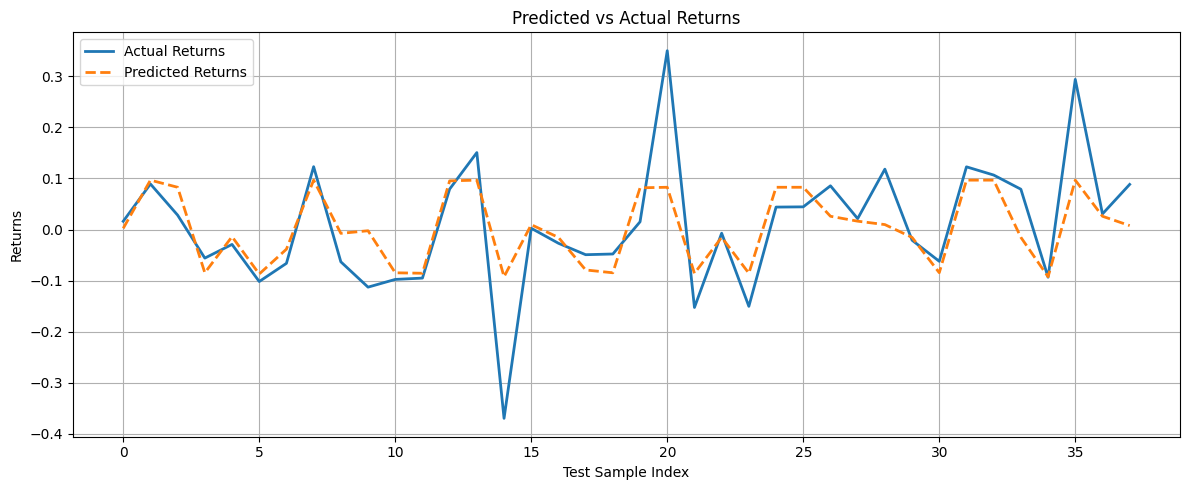

In [183]:
helper.plot_preds_line(y_test, y_pred)

In [186]:
helper.feat_analysis(x_train, y_train, best_model)

⚠️ Model HistGradientBoostingRegressor does not expose feature importance.
